# Showcasing pcrglobwb_utils

This notebook should provide a first impression on what the pcrglobwb_utils package and the functions therein can contribute to evaluating PCR-GLOBWB runs and output.

It contains:

* Extracting meta-data information from [GRDC-stations](#GRDC_info) (name, location);
* [Extracting timeseries](#get_data) from GRDC-file and netCDF-file at specified cell;
* [Validation](#validate) of simulated data with observations;
* [Resampling](#resampling) to different frequencies and using different statistical descriptors;
* Evaluate the different components of the annual [water balance](#water_balance)
* Analyse [ensemble data](#ensembles)

## Preparation

### Load packages

In [34]:
import pcrglobwb_utils
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import rasterio as rio
import spotpy as sp
import os, sys
import datetime

In [35]:
print('this notebook was created using Python', str((sys.version)), 'on a', str(sys.platform),'on', datetime.datetime.now())

this notebook was created using Python 3.8.2 | packaged by conda-forge | (default, Mar  5 2020, 17:29:01) [MSC v.1916 64 bit (AMD64)] on a win32 on 2020-07-24 12:13:57.009485


In [36]:
print('using pcrglobwb_utils version', pcrglobwb_utils.__version__)

using pcrglobwb_utils version 0.1.4.3


### specify paths to input files

In [37]:
# log file of run in Amazon basin
log_fo = 'example_data/setup_30min_Amazon_2005_2010_para.log'

### specify variable names

# Working with timeseries

<a id="GRDC_info"></a>

## Get information about GRDC-station and its location

A data-source often used for validating simulated discharge is the Global Runoff Data Centre (GRDC; https://portal.grdc.bafg.de/applications/public.html?publicuser=PublicUser#). With the functions implemented in pcrglobwb_utils, it becomes much more straightforward to validate simulated discharge with GRDC-data. All is needed is the nc-file containing simulated discharge and the GRDC-file containing observed values.

In [38]:
##- create a python-object for the GRDC-data, here daily values
grdc_obj = pcrglobwb_utils.obs_data.grdc_data('example_data/3629000_Obidos.day')

In [39]:
##- get a simple plot_title and properties (as dictionary) for this GRDC station
plot_title, props = grdc_obj.get_grdc_station_properties()
print(plot_title)
print(props)

station OBIDOS - PORTO at latitude/longitude -1.947200/-55.511100
{'station': 'OBIDOS - PORTO', 'latitude': -1.9472, 'longitude': -55.5111}


We now know where this specific location is located based on lat/lon information. This in turn can be employed to find the corresponding cell in the netCDF-file and extract a timeseries of simulated discharge from there.

In [40]:
##- based on lon/lat information of GRDC station, find corresponding row/col indices in nc-file
row, col = pcrglobwb_utils.utils.find_indices_from_coords('example_data/DUMMY_discharge_dailyTot_output.nc', 
                                                          props['longitude'], props['latitude'])

print('The location {} with its latitude {} and longitude {} corresponds to the cell with row and cell indeces {}'.format(props['station'], 
                                                                                                                         props['latitude'], 
                                                                                                                         props['longitude'],
                                                                                                                         (row, col)))

The location OBIDOS - PORTO with its latitude -1.9472 and longitude -55.5111 corresponds to the cell with row and cell indeces (17, 50)


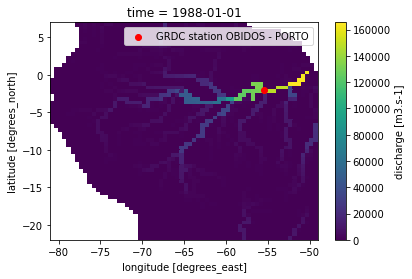

In [41]:
# for visualization purposed, it is also possible to plot variable from nc-file for given data
# and also location of GRDC station on the map
plt.figure()
pcrglobwb_utils.plotting.plot_var_at_timestep('example_data/DUMMY_discharge_dailyTot_output.nc', 
                                              var_name='discharge', 
                                              time='1988-01-01')
plt.scatter(props['longitude'], props['latitude'], c='r', label='GRDC station {}'.format(props['station']))
plt.legend();

<a id="get_data"></a>

## Reading values files and visualzing them

### From GRDC file

We already know the station name and where the GRDC-station is located. Now let's get to the pudels kern and get the timeseries of observed discharge at this station.

In [42]:
##- reading values from GRDC-station text file and converting it to dataframe, employing a user-specified variable name
df_GRDC, props = grdc_obj.get_grdc_station_values(var_name='Q$obs$ GRDC [m3/s]', plot=False)

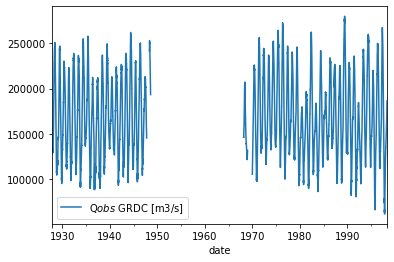

In [43]:
##- plot the timeseries
df_GRDC.plot();

Once we have retrieved the timeseries, the station properties are updated with the startdate and enddate of observations. Note, that this does not say anything about the number of missing values in this timeseries and when they occur!

In [44]:
print('Start data of the observations is {} and the end data is {}'.format(props['start_data_obs'], props['end_data_obs']))

Start data of the observations is 12/01/1927 and the end data is 05/31/1998


### From Excel file

If the file is not structured like GRDC files but an Excel-file with one sheet containing two columns (date and value), we could do the same by reading from a non-GRDC formatted Excel-file.

Note: for this example the GRDC data was copied into an Excel-file, thus the absolute agreement between both timeseries.

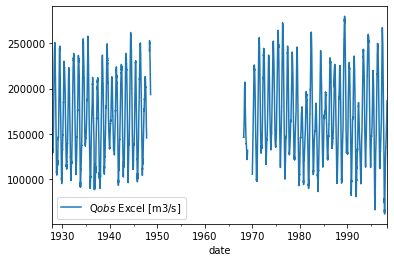

In [45]:
##- first, create a python-object 
excel_obj = pcrglobwb_utils.obs_data.other_data('example_data/Obidos_data.xlsx')

# second, apply method
df_excel = excel_obj.get_values_from_excel(var_name='Q$obs$ Excel [m3/s]',
                                     plot=True,
                                     remove_mv=True)

### From nc-file

Thus far, we looked mostly at observed values. Time to check out the simulated values too! To that end, we need to create a python-object first, merely using the netCDF-file containing PCR-GLOBWB output (in fact, this should work with any netCDF-file!).

In [46]:
##- create object first
nc_object = pcrglobwb_utils.sim_data.from_nc('example_data/DUMMY_discharge_dailyTot_output.nc')

Above, we already determined the row and column indices of the GRDC-station we use for model validation. These indices now serve as input to retrieve the timeseries from the netCDF-file and store it as dataframe.

In [47]:
# apply method to read values at specific row and col
q_sim_obidos = nc_object.read_values_at_indices(row, col, plot_var_name='Q$sim$ PCR-GLOBWB [m3/s]', plot=False)

Together with the dataframe containing the observed values, we can now finally compare the timeseries!

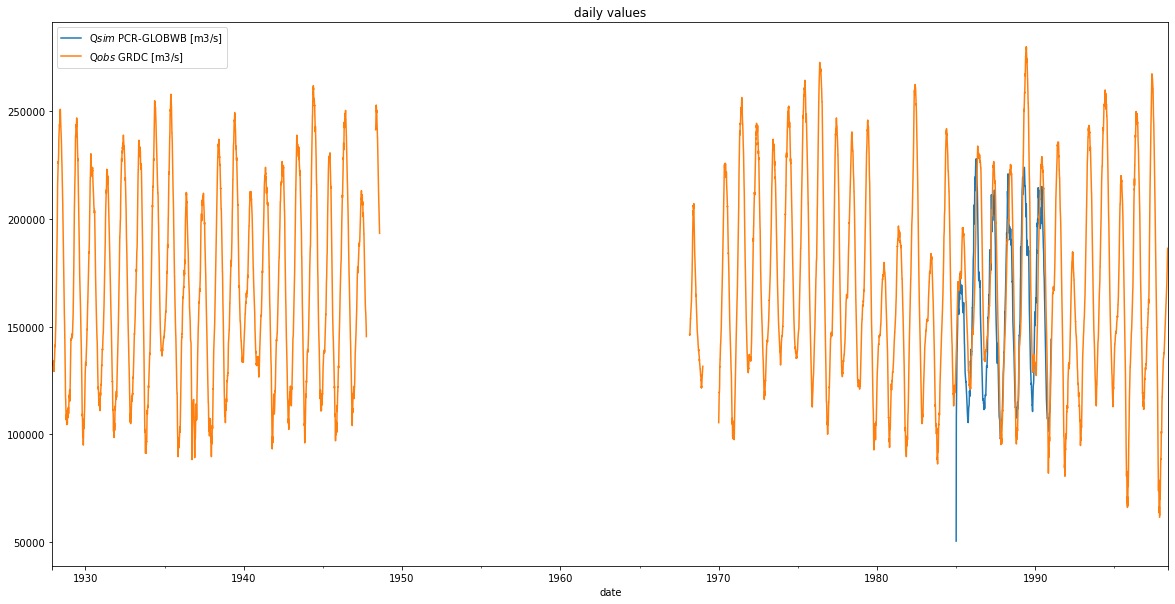

In [48]:
fig, ax = plt.subplots(1, 1, figsize=(20,10))
q_sim_obidos.plot(ax=ax)
df_GRDC.plot(ax=ax)
plt.legend()
plt.title('daily values');

<a id="validate"></a>

## Validation of daily values

Eventually, we do not only want to look at timeseries, but validate the accuracy of simulated discharge. Currently, we can compute the KGE (with or without its components), NSE, RMSE, and R2 based on simulations and observations. To do so, both timeseries are clipped to the common period and missing values are removed.

In [49]:
##- validating simulations with observations for common time period
df_eval, eval_dic = nc_object.validate_results(df_GRDC, out_dir='./_OUT', return_all_KGE=True)

In [50]:
print('Calculated KGE is {}, NSE is {}, RMSE = {}, and R2 = {}'.format(eval_dic['KGE'][0],
                                                                       eval_dic['NSE'],
                                                                       eval_dic['RMSE'],
                                                                       eval_dic['R2']))

Calculated KGE is 0.7121953016339049, NSE is 0.49627672211755103, RMSE = 30911.840814351533, and R2 = 0.5995766148762273


In [51]:
print('in case it is specified, the components of the KGE are: correlation {}, ratio of the standard deviation {}, and ratio of the mean {}'.format(eval_dic['KGE'][1],
                                                                                                                                                    eval_dic['KGE'][2],
                                                                                                                                                    eval_dic['KGE'][3]))

in case it is specified, the components of the KGE are: correlation 0.7743233270903229, ratio of the standard deviation 0.8402090027540561, and ratio of the mean 0.9201976134118512


In case the statistical properties of the timeseries are of interest, this can be provided as well. If needed, also a histogram can be plotted.

In [52]:
stats = nc_object.calc_stats(out_dir='./_OUT', plot=False)
stats

,Q$obs$ GRDC [m3/s],Q$sim$ PCR-GLOBWB [m3/s]
count,17988.000000,2191.000000
mean,169489.883533,157987.046875
std,45071.997625,36602.886719
min,61500.000000,50378.406250
25%,134300.000000,123427.546875
50%,163425.000000,157203.796875
75%,208000.000000,191713.609375
max,280000.000000,228026.765625


<a id="resampling"></a>

## Resampling over time using different statistical descriptors

### Averaging

It is also possible to resample timeseries from, for instance, daily values to monthly or even yearly values. Currently, this resampling can be done using the monthly/yearly mean (default setting) as well as by determining minimum and maximum value per month or year.

In [53]:
GRDC_data_monthly = grdc_obj.resample2monthly(stat_func='mean', suffix='_monthly')

In [54]:
q_sim_obidos_monthly = nc_object.resample2monthly(stat_func='mean', suffix='_monthly')
q_sim_obidos_monthlyMAX = nc_object.resample2monthly(stat_func='max', suffix='_monthly')
q_sim_obidos_monthlyMIN = nc_object.resample2monthly(stat_func='min', suffix='_monthly')

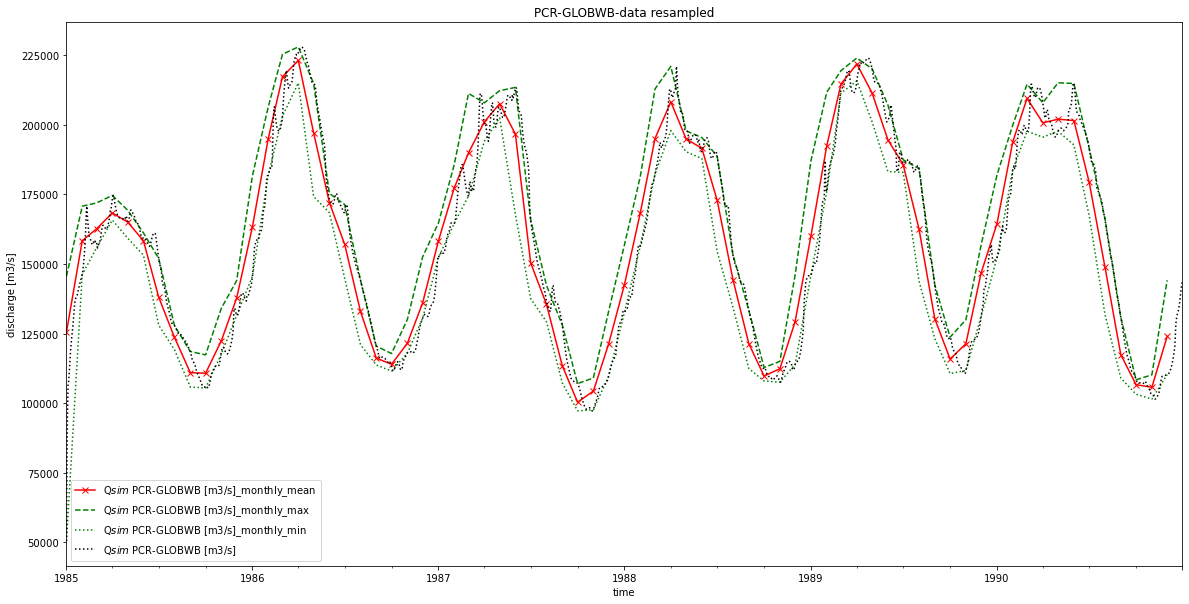

In [55]:
ax = q_sim_obidos_monthly.plot(c='r', marker='x', figsize=(20,10))
q_sim_obidos_monthlyMAX.plot(ax=ax, c='g', linestyle='--')
q_sim_obidos_monthlyMIN.plot(ax=ax, c='g', linestyle=':')
q_sim_obidos.plot(ax=ax, c='k', linestyle=':', title='PCR-GLOBWB-data resampled')
ax.set_ylabel('discharge [m3/s]');

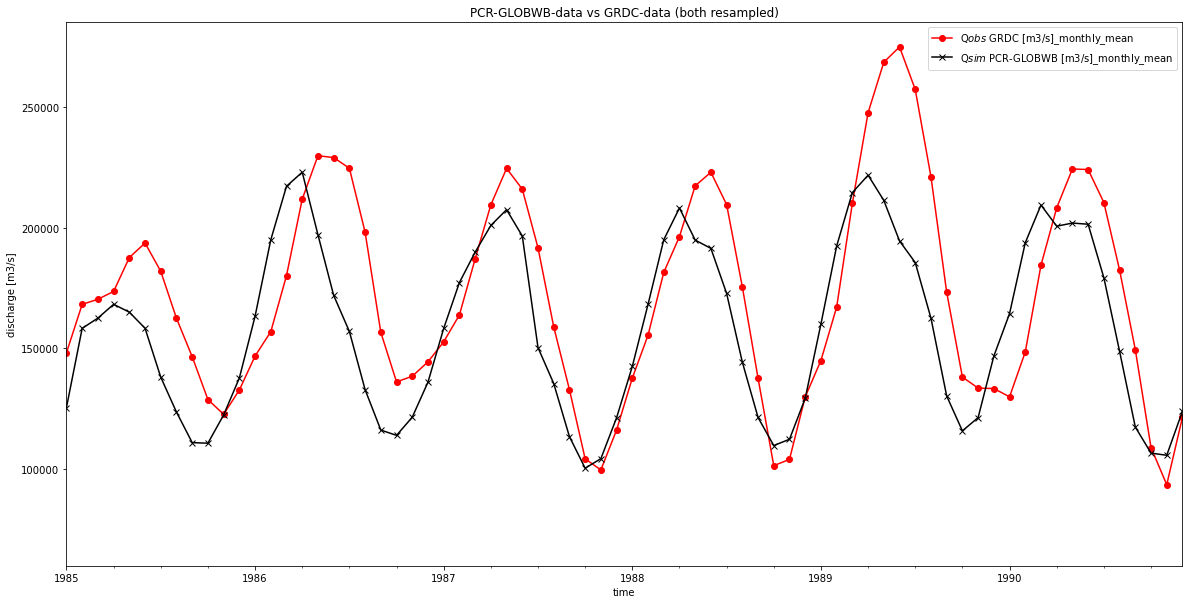

In [56]:
ax = GRDC_data_monthly.plot(c='r', marker='o', figsize=(20,10))
q_sim_obidos_monthly.plot(ax=ax, c='k', marker='x', title='PCR-GLOBWB-data vs GRDC-data (both resampled)')
ax.set_ylabel('discharge [m3/s]')
ax.set_xlim(q_sim_obidos_monthly.index.values[0], q_sim_obidos_monthly.index.values[-1]);

<a id="water_balance"></a>

# Analyzing the water balance of a run

By parsing the water balance statements in the log file, it is possible to get the annual values of different water balance components.

In [57]:
# first, create a water balance object based on the log-file
wb = pcrglobwb_utils.water_balance.water_balance(log_fo)

In [58]:
# now get annual values of the components
wb.get_annual_values()

,year,precipitation,actualET,runoff,totalPotentialGrossDemand,baseflow,storage
0,2004,19290.19,8567.613,7803.257,0.0,6236.654,2919.32300
1,2005,19323.89,8585.006,8773.407,0.0,7164.631,1965.49800
2,2006,20774.36,8639.188,10510.080,0.0,8836.278,1625.08700
3,2007,19292.14,8477.911,10059.490,0.0,8551.246,754.76360
4,2008,20996.61,8543.917,11480.840,0.0,9886.425,971.79970
5,2009,19872.88,8748.335,11157.260,0.0,9630.766,-32.68977


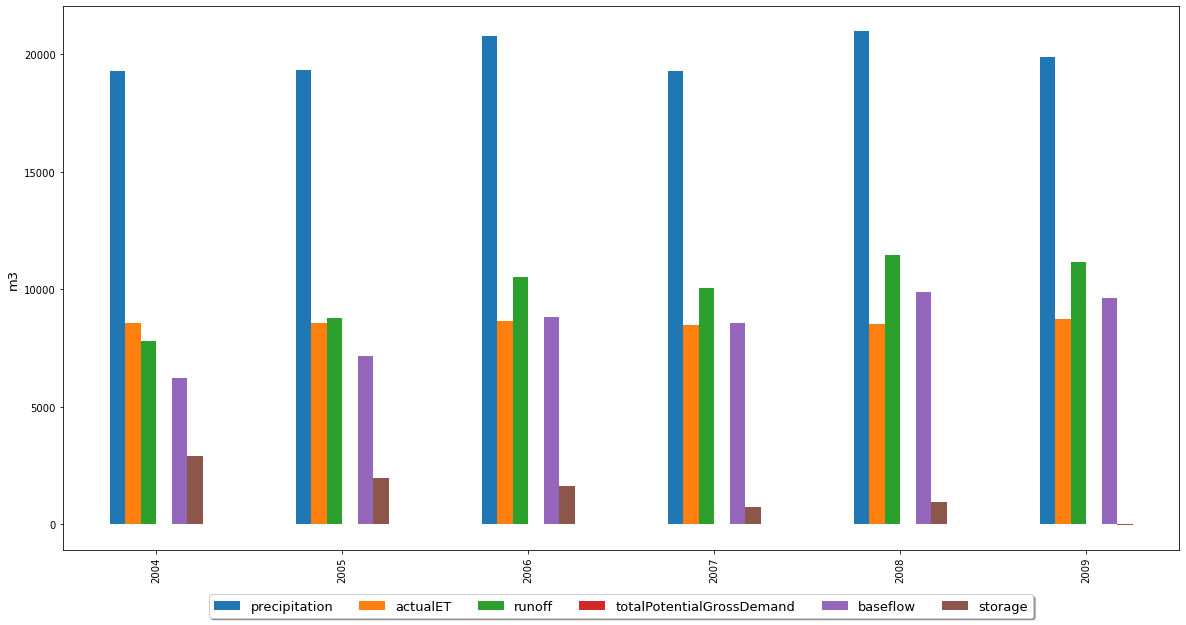

In [59]:
# it is also possible to directly plot them as bar plot
wb.bar_plot()

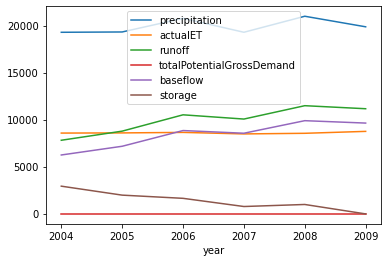

In [60]:
# alternatively, the dataframe can be retrieved and all pandas plotting options are available
wb_vals = wb.get_annual_values()
wb_vals.plot(x='year')

<a id="ensembles"></a>

# Ensembles

If more than one run is performed but an ensemble (e.g. with different RCPs), it can be useful to automatically compute and vizualize the mean, max, and min of the ensemble. pcrglobwb_utils contains a few functions to facilitate working with ensembles.

Since we only have output from one run here, we compute some dummy time series first by multiplying the actual data with random factors.

In [61]:
##- get some random values for the factors
fact_arr = np.random.rand(9)

In [62]:
##- create a list with dummy timeseries, representing a range of ensemble runs
q_ens = [q_sim_obidos]
for factor, i in zip(fact_arr, range(len(fact_arr))):
    q_temp = q_sim_obidos.mul(factor)
    q_temp = q_temp.rename(columns={'Q$sim$ PCR-GLOBWB [m3/s]': i+1})
    q_ens.append(q_temp)

The code currently works like this that you need to separately provide a dataframe per ensemble you want to have analysed. This gives more flexibilty in handling the data input.

In [63]:
ens_obj = pcrglobwb_utils.ensembles.ensemble_data(q_ens[0], q_ens[1], q_ens[2], q_ens[4], q_ens[5], q_ens[9])

We can now calculate the mean, max, and min of the timeseries.

In [64]:
df_ens = ens_obj.calc_stats()
df_ens.head()

,Q$sim$ PCR-GLOBWB [m3/s],1,2,4,5,9,mean,max,min
time,,,,,,,,,
1985-01-01,50378.406250,2150.764893,47945.890625,39227.316406,159.997681,41801.132812,30277.250000,50378.406250,159.997681
1985-01-02,80150.671875,3421.808350,76280.609375,62409.593750,254.551956,66504.468750,48170.281250,80150.671875,254.551956
1985-01-03,95131.804688,4061.385986,90538.375000,74074.703125,302.130798,78934.960938,57173.890625,95131.804688,302.130798
1985-01-04,106136.960938,4531.220215,101012.148438,82643.906250,337.082275,88066.406250,63787.957031,106136.960938,337.082275
1985-01-05,107144.250000,4574.223633,101970.804688,83428.234375,340.281342,88902.203125,64393.332031,107144.250000,340.281342


Furthermore, this information allows us to plot the span of values per timestep as a graph.

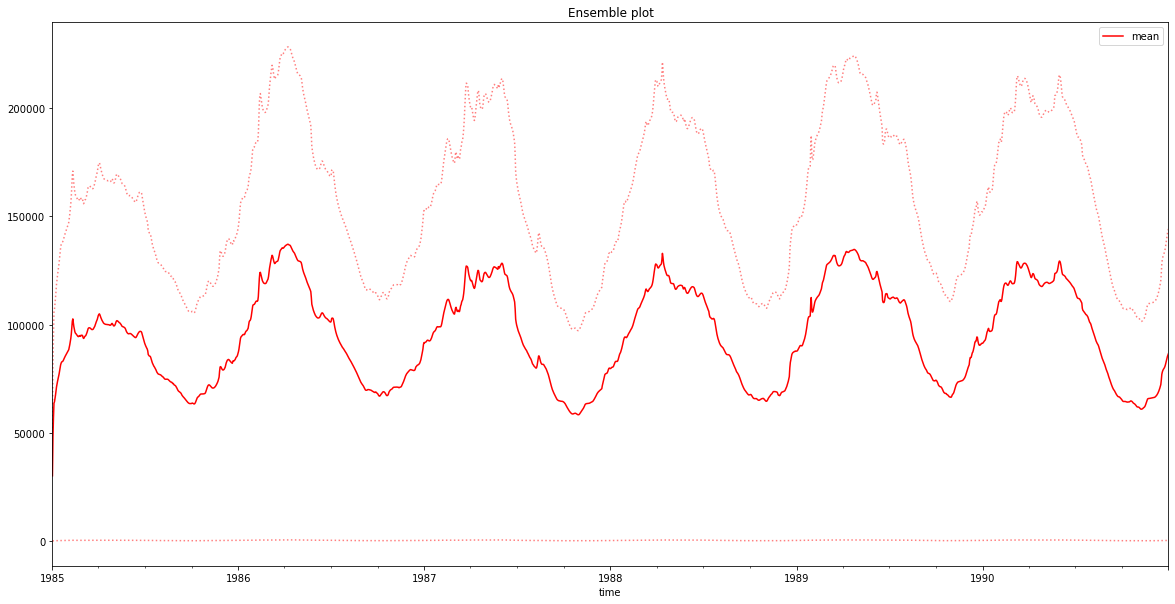

In [65]:
ens_obj.plot_bounds()

### Climatology

Sometimes it is good to know what the mean value is per month averaged the entire timeseries. This can be done with the subsequent function.

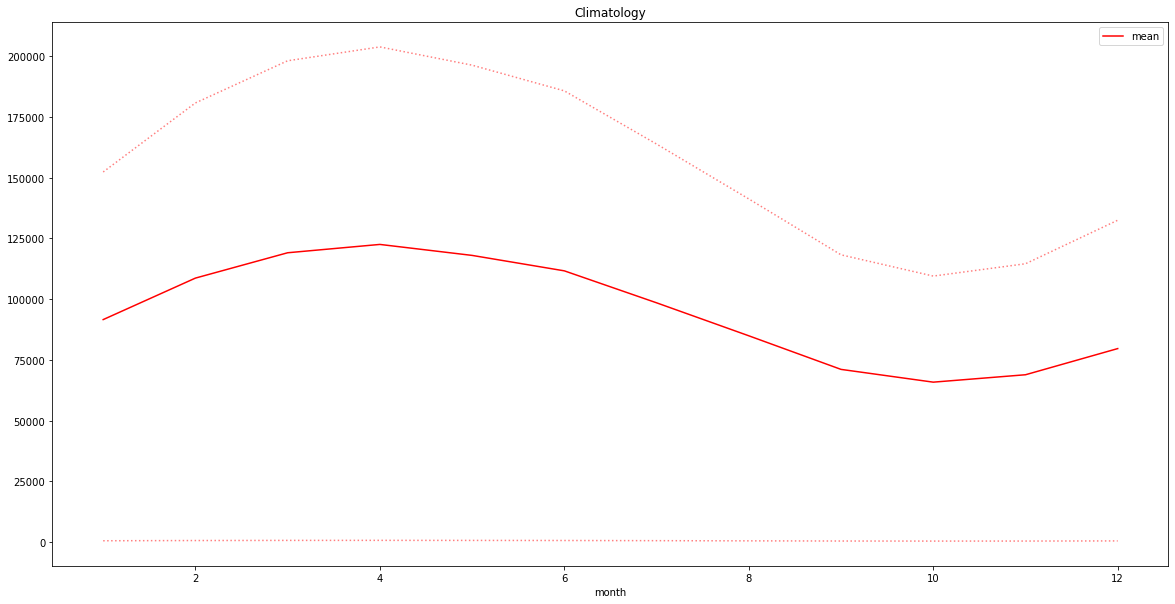

In [66]:
df_ens_monthAvg = ens_obj.climatology(plot=True);

## GRACE and GLEAM validation

In [ ]:
pcrglobwb_utils.spatial_validation.